In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [130]:
raw = pd.read_csv('interview_task_data.csv')

In [217]:
X = raw.iloc[:,1:10]
y = raw['label']

In [223]:
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

import shap
import warnings
warnings.filterwarnings("ignore")

In [ ]:
seed = 1234

logit = LogisticRegression(random_state=seed)
rf_clf = RandomForestClassifier(random_state=seed)
xgb_clf = XGBClassifier(random_state=seed, probability=True)
lgb_clf = LGBMClassifier(random_state=seed)

linear = LinearRegression()
en = ElasticNet(random_state=seed)
rf_reg = RandomForestRegressor(random_state=seed)
xgb_reg = XGBRegressor(random_state=seed)
lgb_reg = LGBMRegressor(random_state=seed)


clf_list = {'LogisticRegression': logit,
            'RandomForest': rf_clf, 
            'XGBoost': xgb_clf,
            'LightGBM': lgb_clf}
reg_list = {'LinearRegression': linear,
            'ElasticNet': en,
            'RandomForest': rf_reg, 
            'XGBoost': xgb_reg,
            'LightGBM': lgb_reg}

# Hyper-prameters tuning using gridsearch

clf_pram_grid_list = {'LogisticRegression' : {'C': np.logspace(-4, 4, 20), 
                                          'max_iter': [1000], 
                                          'fit_intercept':[True, False],
                                          'penalty':['l1', 'l2']},
             'RandomForest' : {'max_depth': [3, 5, 6, 7, 8], 
                               'max_features': ['auto', 'sqrt'], 
                               'n_estimators': [20, 50, 100, 200],
                               'min_samples_split': [3, 5, 6, 7]},
             'XGBoost' : {'min_child_weight': [1, 5, 10],
                            'gamma': [0.5, 1, 1.5, 2, 5],
                            'subsample': [0.6, 0.8, 1.0],
                            'colsample_bytree': [0.6, 0.8, 1.0],
                            'max_depth': [3, 4, 5]}
            }

reg_pram_grid_list = {'LogisticRegression' : {'C': np.logspace(-4, 4, 20), 
                                          'max_iter': [1000], 
                                          'fit_intercept':[True, False],
                                          'penalty':['l1', 'l2']},
             'RandomForest' : {'max_depth': [3, 5, 6, 7, 8], 
                               'max_features': ['auto', 'sqrt'], 
                               'n_estimators': [20, 50, 100, 200],
                               'min_samples_split': [3, 5, 6, 7]},
             'XGBoost' : {'min_child_weight': [1, 5, 10],
                            'gamma': [0.5, 1, 1.5, 2, 5],
                            'subsample': [0.6, 0.8, 1.0],
                            'colsample_bytree': [0.6, 0.8, 1.0],
                            'max_depth': [3, 4, 5]}
            }

#### Train-test Split

In [24]:
target = 'label'

In [25]:
# Split dataset into CV (80%) and holdout (20%)
seed = 1234

def 
train_val, holdout = model_selection.train_test_split(model_df, test_size=0.2, 
                                                      random_state=seed)
X_train = train_val.drop(columns=target)
y_train = train_val[target].values
X_holdout = holdout.drop(columns=target)
y_holdout = holdout[target].values


#### Model Selection

In [28]:
# Get score for different classifiers
import time

def auto_hyperparameter_tuning(model_list, X_train, y_train):
    # Store best estimators after hyperparamter tuning
    best_estimators = {}
    
    for (name, mod) in model_list.items():
        start_time = time.time()
        
        # Hyper-paramters tuning 
        
        grid = model_selection.RandomizedSearchCV(mod, 
                                     pram_grid_list[name], 
                                     cv=5, refit=True, verbose=0)
        # use small sample to speed up training
        # parameters performing well in small sample will also perform well in larger sample
        if X_train.shape[0] >= 1000:
            grid.fit(X = X_train[:1000], y = y_train[:1000])
        else:
            grid.fit(X = X_train, y = y_train)
        
        end_time = time.time()
        best_estimators[name] =  grid.best_estimator_
        
    return best_estimators

def auto_model_selection(model_list, X_train, y_train, metrics):
    
    result_df = pd.DataFrame(columns=['Model', 'Time Spent', 'CV'])
    for (name, mod) in model_list.items():
        start_time = time.time()
        
        # Use 5-fold cross validation
        cv_results = model_selection.cross_validate(mod, 
                                       y = y_train, 
                                       X = X_train, 
                                       cv=5,
                                       scoring=metrics
                                      )
        cv_score = cv_results['test_score']
        
        end_time = time.time()
        time_spent = (end_time - start_time) / 60
        result_df.loc[len(result_df)] = [name,
                                          round(time_spent,1), 
                                          np.round(cv_score.mean(), 4)]
    return result_df

In [29]:
# Model selections
# This takes very very long time due to hyperparamter tuning

result_df, best_estimators = print_model_results(model_list, 
                                                 X_train, 
                                                 y_train)
print(result_df)

                Model  Time Spent      CV
0  LogisticRegression         0.2  0.6969
1        RandomForest         0.2  0.7152
2             XGBoost         0.6  0.7217


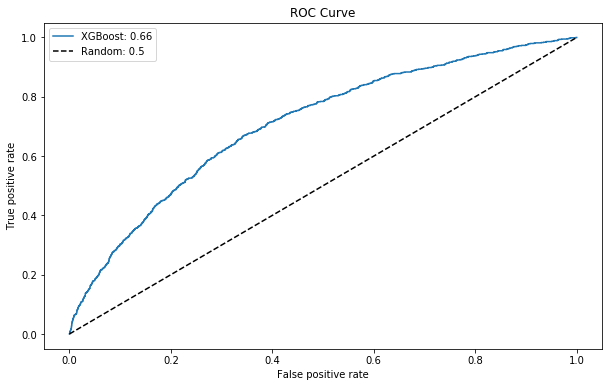

In [30]:
## Best model on holdout set

# train the model with the whole training set

final_model = best_estimators['XGBoost'].fit(y = y_train, X = X_train)

def get_auc_scores(y_actual, pred_label, pred_proba):
    auc_score = metrics.roc_auc_score(y_actual, pred_label); 
    fpr_df, tpr_df, _ = metrics.roc_curve(y_actual, pred_proba); 
    return (auc_score, fpr_df, tpr_df)

def draw_roc_curve(auc_, fpr_, tpr_, mod_label, figsize = (10,6))
    plt.figure(figsize = figsize, linewidth= 1)
    plt.plot(fpr_, tpr_, label = mod_label + ': ' + str(round(auc_, 2)))
    plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### Feature Importance (Explain the model)

In [206]:
import shap

In [229]:
# Evaluate feature importance using SHAP



def draw_feature_importance(model, explainer, X_train):
    try:
        if explainer == 'tree':
            shap_values = shap.TreeExplainer(model).shap_values(X_train)
        elif explainer == 'linear':
            shap_values = shap.LinearExplainer(model).shap_values(X_train)
        ax = shap.summary_plot(shap_values, X_train, plot_type="bar")
    except Exception as e:
        print(model, str(e))
    return ax

#### Find the optimal threshold for deployment

In [230]:
# I will use f2 score to optimise the threshold based on the following assumptions
# 1) Positive class is more important
# 2) False negative is costly
# F2-Measure (beta=2.0): Less weight on precision, more weight on recall
# Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)

def Find_Optimal_Cutoff(target, pred_proba, beta):
    precision, recall, pr_threshold = metrics.precision_recall_curve(target, pred_proba)
    f2_score = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
    cutoff = pr_threshold[np.where(f2_score==f2_score.max())][0]
    
    ax = sns.lineplot(threshold, f2)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('f2-score')
    plt.show()
    return f2_score[:-1], pr_threshold, cutoff
